In [191]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
import matplotlib
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import os 
import scipy
import uproot
import glob
import yaml
import json

np.seterr(divide='ignore', invalid='ignore')

#plt.style.use('physics.mplstyle')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [192]:
era = 2018
M = 1000
decaymode = 'leptonic'

In [193]:
def get_limits(fn): 
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit]) 
    
def get_SUEP_file(Mass=125, mdark=2, t=1, decay="darkPho", path="./"): 
    if t < 10:
        tem = "{0:.2f}".format(t)
    else:
        tem = "{0:.1f}".format(t)
    tem = str(tem).replace(".","p")
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT1000_T{}_mS{:.3f}_mPhi{:.3f}_T{:.3f}_mode{}_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root".format(tem, Mass, mdark, t, decay)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
     
def log_interp1d(xx, yy, kind='linear'): # Returns a linear interpolation through log(x) and log(y)
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp 


def log_interp2d(xx, yy, zz, method='nearest'): # Returns a linear interpolation through log(x) and log(y)
    logx = np.log(xx)
    logy = np.log(yy)
    logz = np.log(zz)
    points = np.concatenate(((logx.reshape((len(logx),1)), logy.reshape(len(logy),1))), axis=1)
    lin_interp = griddata(points,logz,(logx[None,:], logy[:,None]),method="nearest")
    log_interp = np.power(np.e, lin_interp)
    return log_interp 

def interpLimit(limit, sigma=3):
    x, y = limit.T
    t  = np.linspace(0, 1, len(x))
    t2 = np.linspace(-0.9, 1.2, 100)

    x2 = np.interp(t2, t, x)
    y2 = np.interp(t2, t, y)
    
    x3 = gaussian_filter1d(x2, sigma)
    y3 = gaussian_filter1d(y2, sigma)
    x4 = np.interp(t, t2, x3)
    y4 = np.interp(t, t2, y3)

    return x3, y3

def xs_scale(proc):
    xsec = 1.0
    with open(f"../config/xsections_{era}.json") as file:
            MC_xsecs = json.load(file)
    xsec  = MC_xsecs[proc]["xsec"] # xsection in pb
    # xsec *= MC_xsecs[proc]["kr"] # filter efficiency
    # xsec *= MC_xsecs[proc]["br"] 
    #xsec *= 1000.0 # To change from pb to fb
    assert xsec > 0, "{} has a null cross section!".format(proc)
    return xsec



In [194]:
combine_files = glob.glob("../higgs*{}*.root".format(decaymode))
# print(combine_files)

In [195]:
all_params = []
for file in combine_files:
    file_trim = file.split("HT1000_")[1]
    proc = 'GluGluToSUEP_HT1000_' + file_trim.split('.Asymptotic')[0]
    xsec = xs_scale(proc)
    t = float(file_trim.split("_")[0].replace("p",".")[1:])
    Mass = float(file_trim.split("_")[1][2:])
    mphi = float(file_trim.split("_")[2][4:])
    all_params.append([t,Mass,mphi,xsec])

../higgsCombineGluGluToSUEP_HT1000_T32p0_mS1000.000_mPhi8.000_T32.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


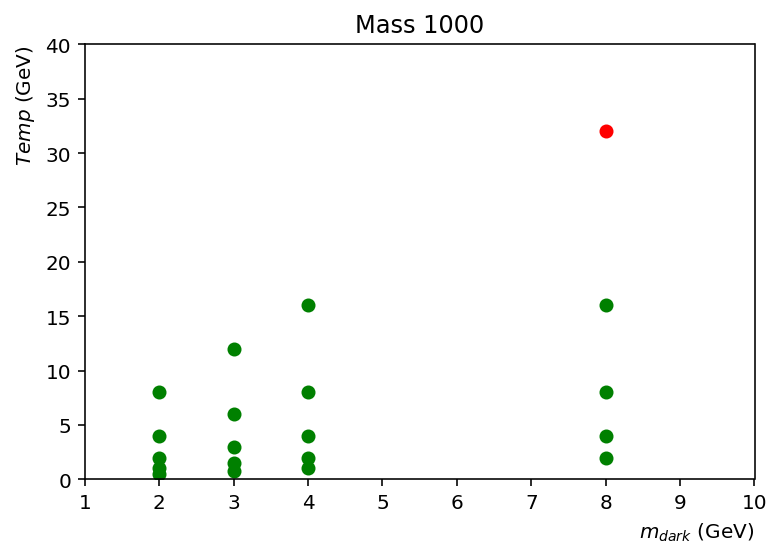

In [196]:
def get_params(M=M):
    params = []
    for pair in all_params:
        if pair[1] != M: continue
        params.append([pair[2],pair[0],pair[3]])

    skip_bad =[]

    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay=decaymode))
        try:
            limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay=decaymode))
            if limit.shape == (2,5):
                plt.scatter(pair[0],pair[1], color="green")
                skip_bad.append(pair)
            else:
                print(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay=decaymode))

                plt.scatter(pair[0],pair[1], color="blue", alpha=0.5)
        except:
            print(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay=decaymode))
            plt.scatter(pair[0],pair[1], color="red")

    plt.ylim([0, 40])
    plt.xlim([1, 10])
    plt.xlabel(r"$m_{dark}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$Temp$ (GeV)", y=1, ha='right')
    plt.title('Mass {}'.format(M))
    plt.show()

    return skip_bad
    
params = get_params(M)


In [216]:
#Plots a 2D limit plot
def plot_SUEP(params=params,unblind=False):
    limit_mH = []
    limit_ma = []
    limit_lm = [] 
    limit_xs = []
    mZ = 91.1876
    return_limit = []

    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay=decaymode))
        limit = limit #* pair[2] # To plot the xsection rather then mu
        if limit.shape == (2, 5):
            limit_lm.append(limit)
            limit_ma.append(pair[0])
            limit_mH.append(pair[1])
            return_limit.append([pair[0], pair[1], limit[1,2]])
            limit_xs.append(pair[2])
        else: 
            continue
            
    limit_lm = np.array(limit_lm)
    limit_mH = np.array(limit_mH)
    limit_ma = np.array(limit_ma)
    limit_xs = np.array(limit_xs)
    
    data = pd.DataFrame(
        {
            "mH"  : np.array(limit_mH),
            "ma"  : np.array(limit_ma),
            "m2s" : np.array(limit_lm)[:,1,0],
            "m1s" : np.array(limit_lm)[:,1,1],
            "exp" : np.array(limit_lm)[:,1,2],
            "p1s" : np.array(limit_lm)[:,1,3],
            "p2s" : np.array(limit_lm)[:,1,4],
            #"obs" : np.array(limit_lm)[:,1,5],
        }
    )
    plt.figure(figsize=(6,6))
    ax = plt.gca()

    _exp = np.array([l[1][2] for l in limit_lm])
    _s1p = np.array([l[1][1] for l in limit_lm]) 
    _s1m = np.array([l[1][3] for l in limit_lm]) 
    _s2p = np.array([l[1][0] for l in limit_lm]) 
    _s2m = np.array([l[1][4] for l in limit_lm]) 
    # _obs = np.array([l[1][5] for l in limits])    

    # Define interpolation
    exp_limit = log_interp2d(limit_ma, limit_mH, zz=_exp)
    s1p_limit = log_interp2d(limit_ma, limit_mH, zz=_s1p)
    s1m_limit = log_interp2d(limit_ma, limit_mH, zz=_s1m)
    s2p_limit = log_interp2d(limit_ma, limit_mH, zz=_s2p)
    s2m_limit = log_interp2d(limit_ma, limit_mH, zz=_s2m)
    #obs_limit = log_interp2d(limit_ma, limit_mH, zz=_obs)

    xx2, yy2 = np.meshgrid(limit_ma, limit_mH)
    xvar = np.array(xx2).flatten()
    yvar = np.array(yy2).flatten()
    
    
    levels = 10.**np.arange(-3,3,0.25)
    x = plt.tricontourf(limit_ma, limit_mH, limit_lm[:,1,2], locator=ticker.LogLocator(), levels =levels, norm = colors.LogNorm(), cmap="Wistia")
    formatter = ticker.LogFormatter(base=10.0, labelOnlyBase=True) 
    cb = plt.colorbar(format=formatter)
    cb.locator = ticker.LogLocator(base=10.0, subs=[1.0], numdecs=7, numticks=45)
    cb.update_ticks()
    
    
    #p0 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,0],levels=[0,1], colors="k", alpha=0) # -2 sigma expected
    p1 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,1],levels=[0,1],  norm = matplotlib.colors.LogNorm(), colors="k", alpha=0) # -1 sigma expected
    p2 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,2],levels=[0,1], locator=ticker.LogLocator(), norm = matplotlib.colors.LogNorm(), colors="k", alpha=0) # median expected
    p3 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,3],levels=[0,1], norm = matplotlib.colors.LogNorm(), colors="k", alpha=0) # +1 sigma expected
    #p4 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,4],levels=[0,1],  colors="k", alpha=0) # +2 sigma expected
    #p5 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,5],levels=[0,1],  colors="k", alpha=0) # observed
    
    #For log 2D interpolation
    #p0 = plt.tricontour(xvar, yvar, s2m_limit.flatten(),levels=[0,1],  colors="k", alpha=0) # +2 sigma expected
    #p1 = plt.tricontour(xvar, yvar, s1m_limit.flatten(),levels=[0,1], colors="k", alpha=0) # -1 sigma expected
    #p2 = plt.tricontour(xvar, yvar, exp_limit.flatten(),levels=[0,1], colors="k", alpha=0) # median expected
    #p3 = plt.tricontour(xvar, yvar, s1p_limit.flatten(),levels=[0,1], colors="k", alpha=0) # +1 sigma expected
    #p4 = plt.tricontour(xvar, yvar, s2p_limit.flatten(),levels=[0,1],  colors="k", alpha=0) # +2 sigma expected
    # p5 = plt.tricontour(xvar, yvar, obs_limit.flatten(),levels=[0,1],  colors="k", alpha=0) # observed
    
    line1 = np.array(p1.collections[1].get_paths()[0].vertices)
    line2 = np.array(p2.collections[1].get_paths()[0].vertices)
    line3 = np.array(p3.collections[1].get_paths()[0].vertices)
    #line4 = np.array(p4.collections[1].get_paths()[0].vertices)
    #line0 = np.array(p0.collections[1].get_paths()[0].vertices)
    #line5 = np.array(p5.collections[1].get_paths()[0].vertices)
    
    #plot smoothed curve
    plt.plot(*interpLimit(line2,2), "b-", label="Expected $95\%$ CL")
        
    plt.xlabel(r"$m_{dark}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$Temp$ (GeV)", y=1, ha='right')
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 60.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    
    info = plt.text(
        0.05, 0.87, r"$Ms = {}$ GeV""\n""{}".format(str(M),decaymode),
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    
    plt.xlim([1, 10])
    plt.ylim([0, 40])     
    plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    #plt.savefig("{}/color_Temp_mdark_2D_limits_M{}_{}.pdf".format(outdir,M,decay), bbox_inches='tight')
    #plt.savefig("{}/Color_Temp_mdark_2D_limits_M{}_{}.png".format(outdir,M,decay), bbox_inches='tight')
    plt.show()

    
    return line2

../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi4.000_T16.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
../higgsCombineGluGluToSUEP_HT1000_T12p0_mS125.000_mPhi3.000_T12.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


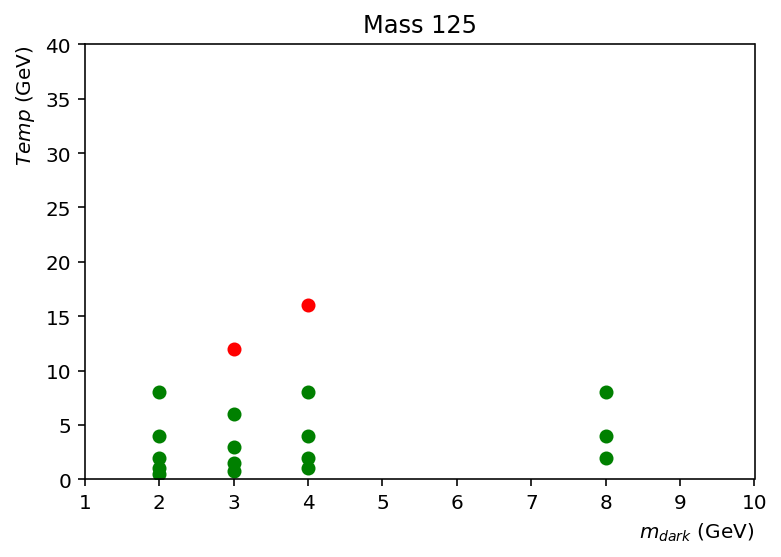

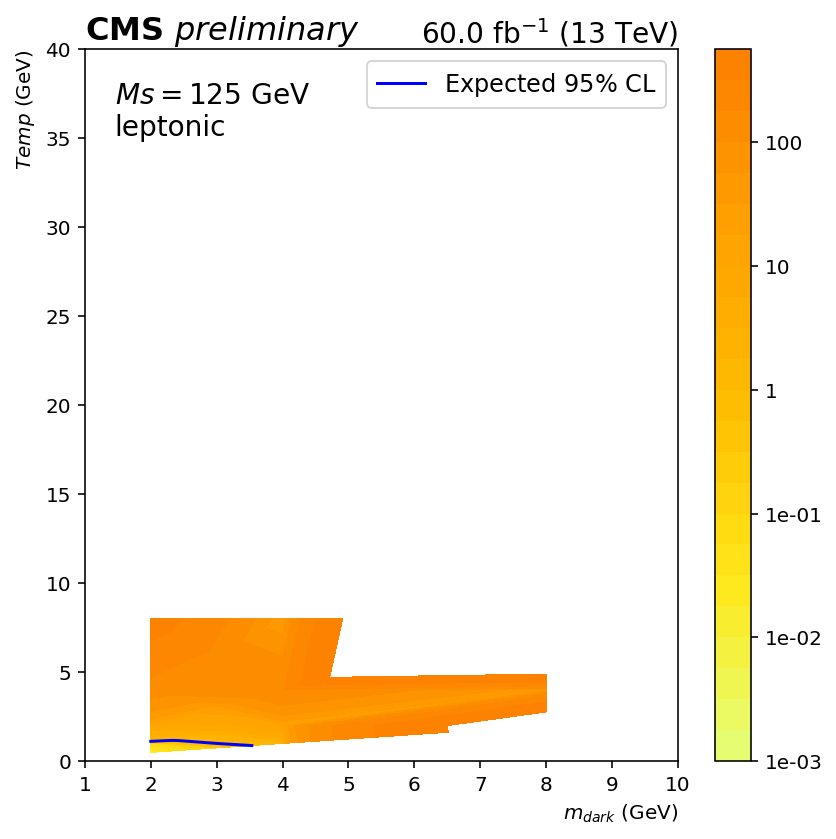

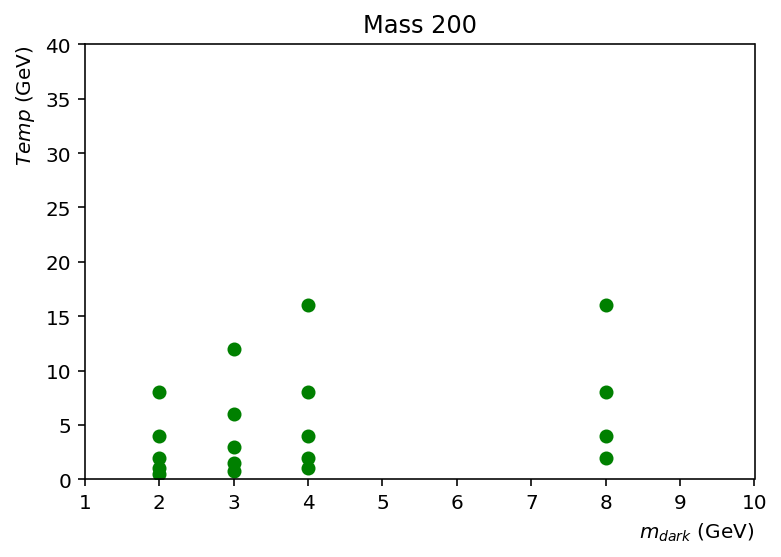

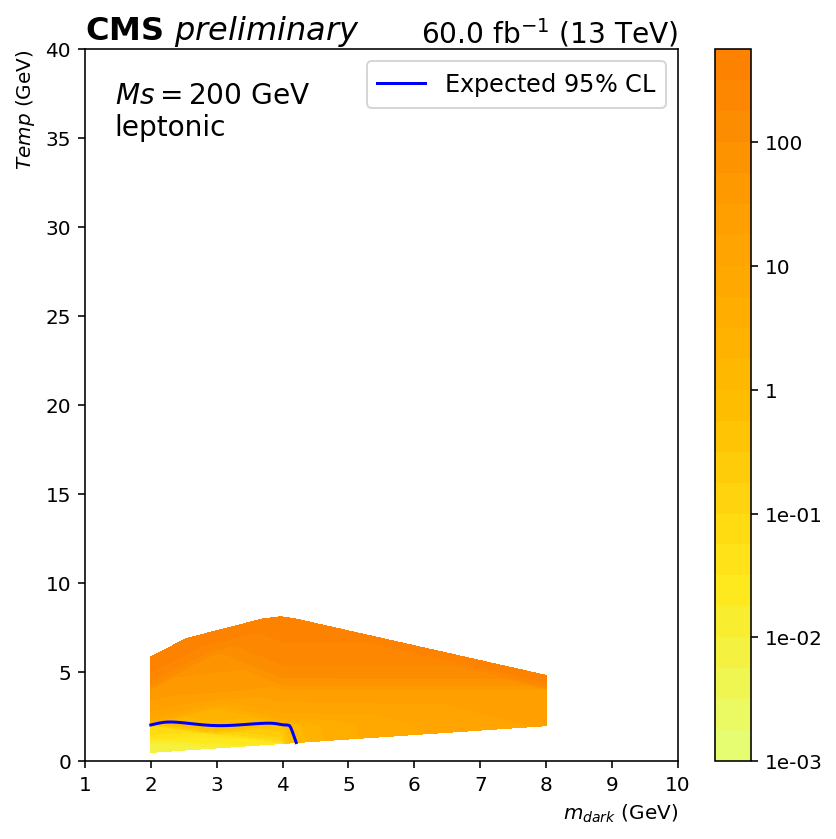

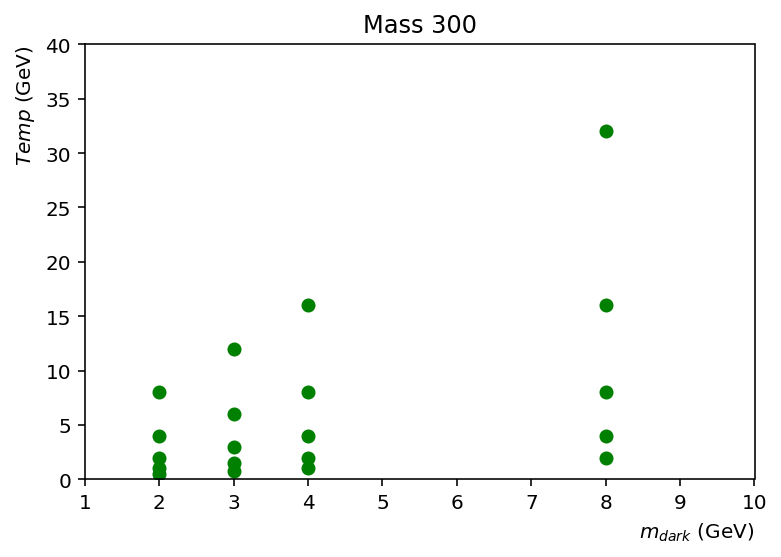

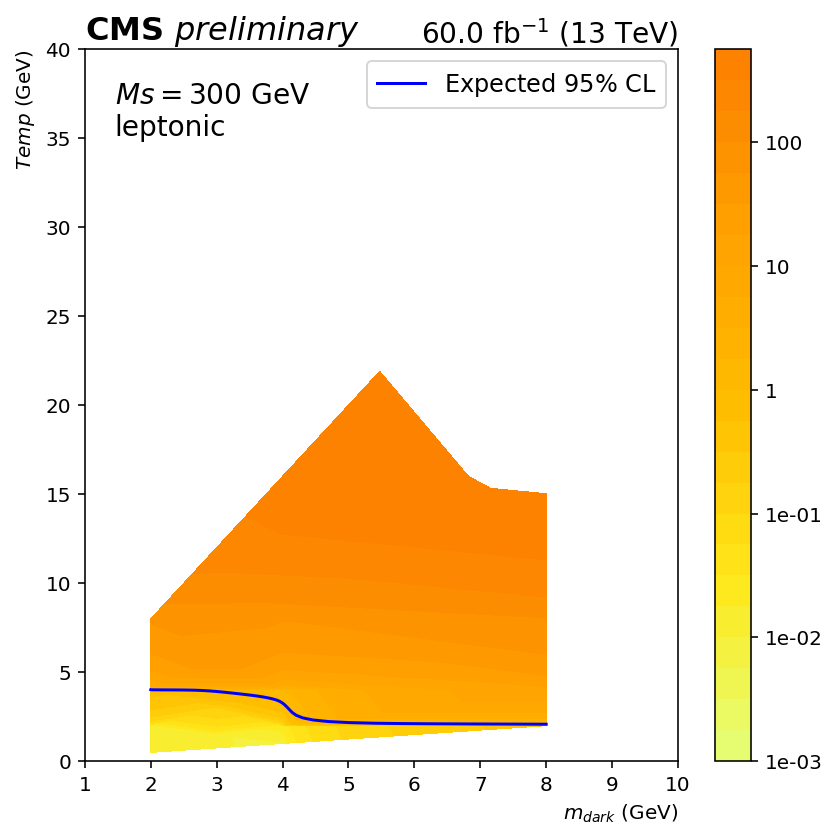

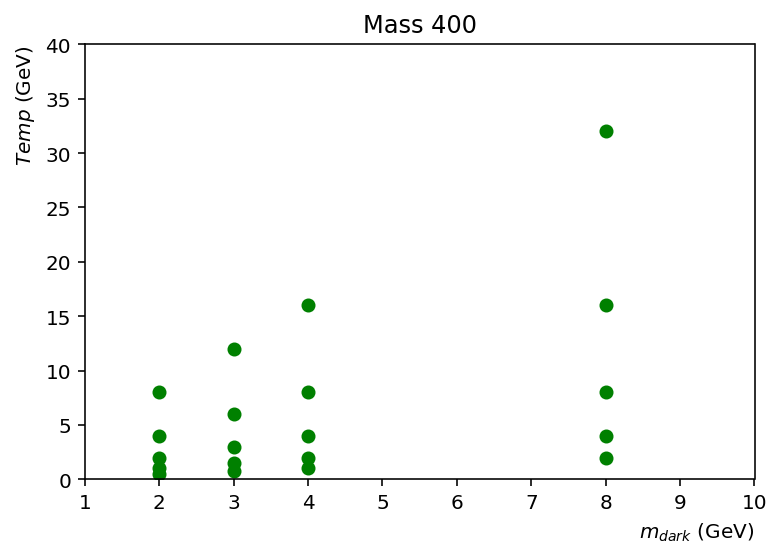

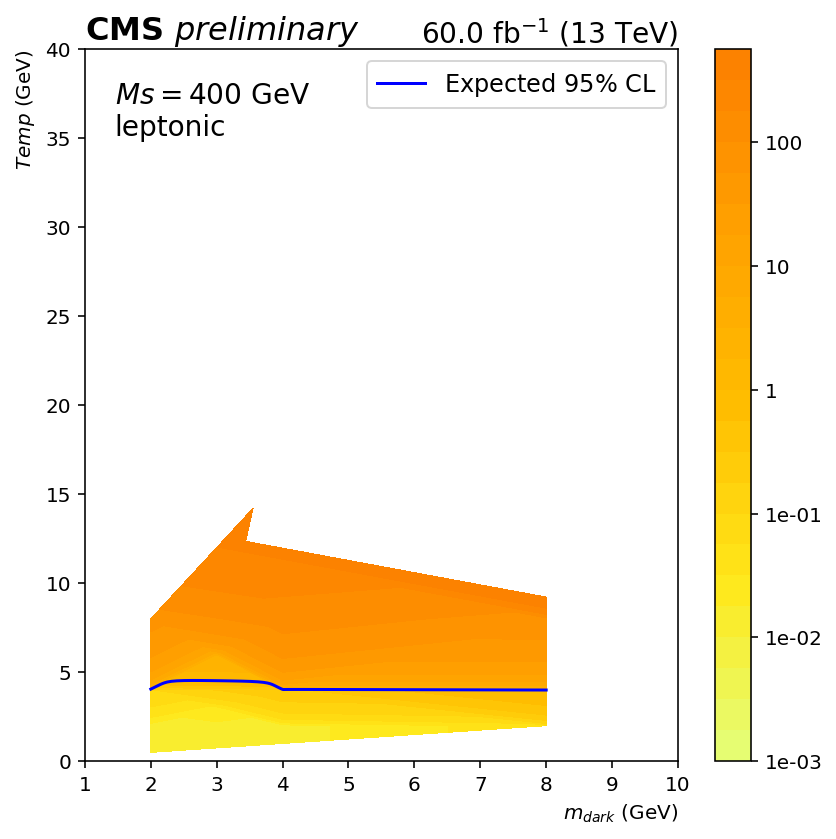

../higgsCombineGluGluToSUEP_HT1000_T32p0_mS500.000_mPhi8.000_T32.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


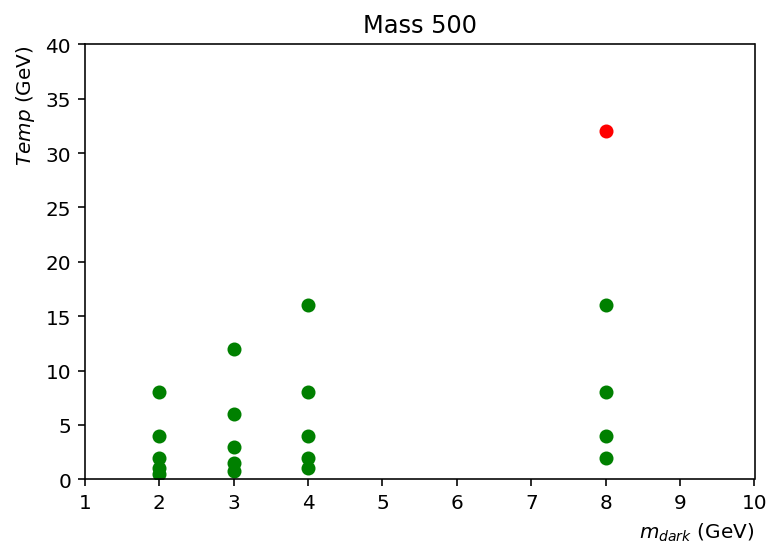

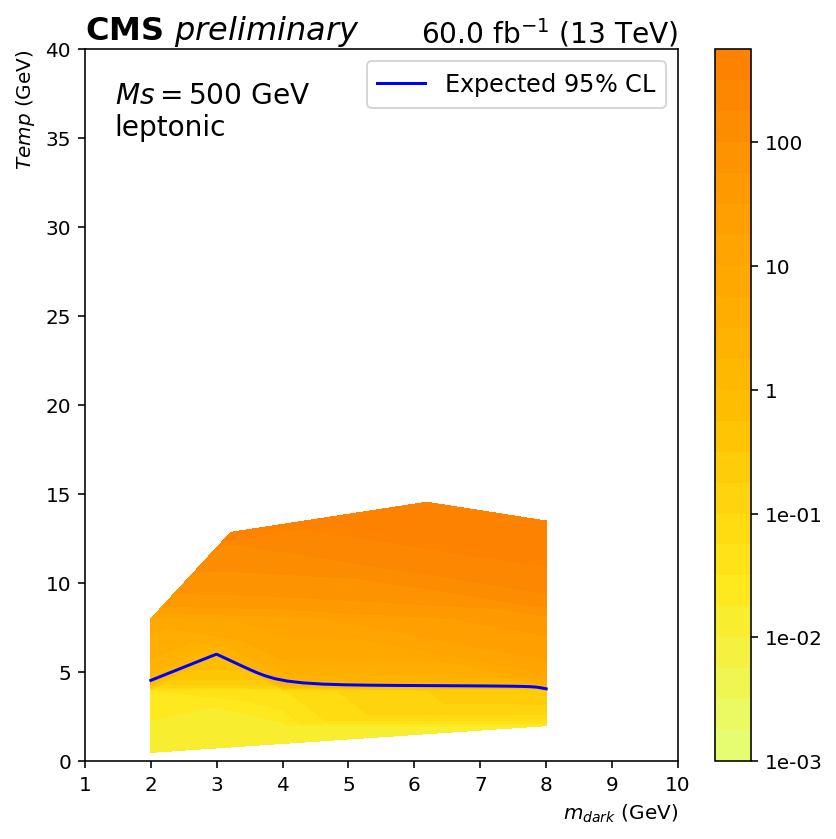

../higgsCombineGluGluToSUEP_HT1000_T1p00_mS600.000_mPhi2.000_T1.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


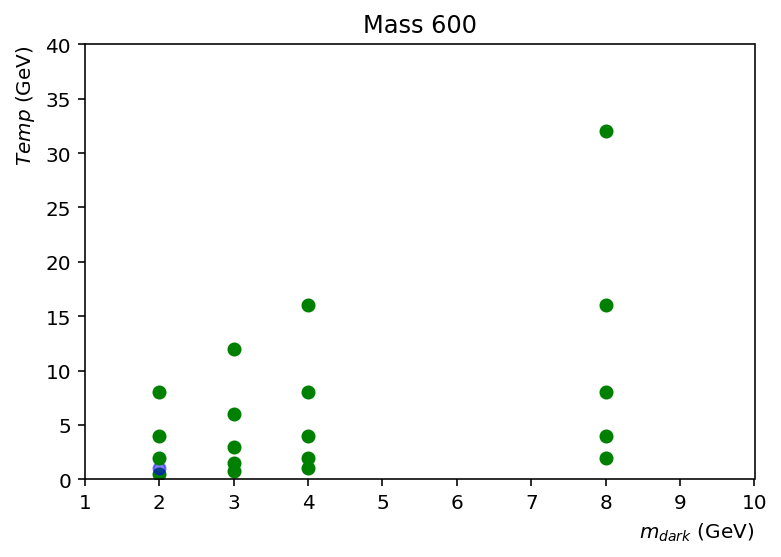

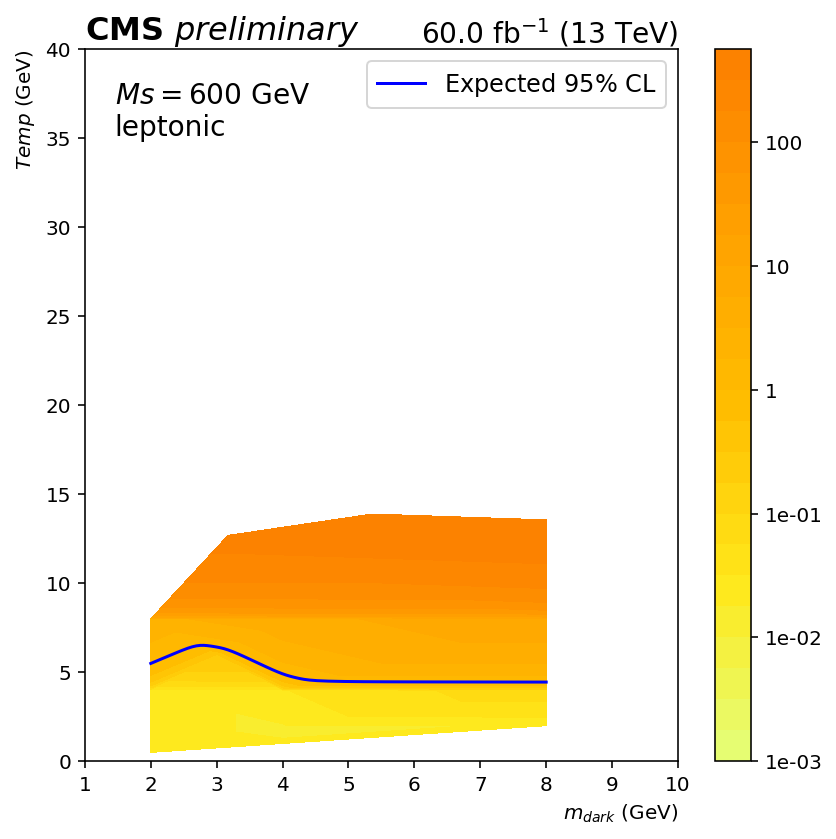

../higgsCombineGluGluToSUEP_HT1000_T0p75_mS700.000_mPhi3.000_T0.750_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
../higgsCombineGluGluToSUEP_HT1000_T4p00_mS700.000_mPhi8.000_T4.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


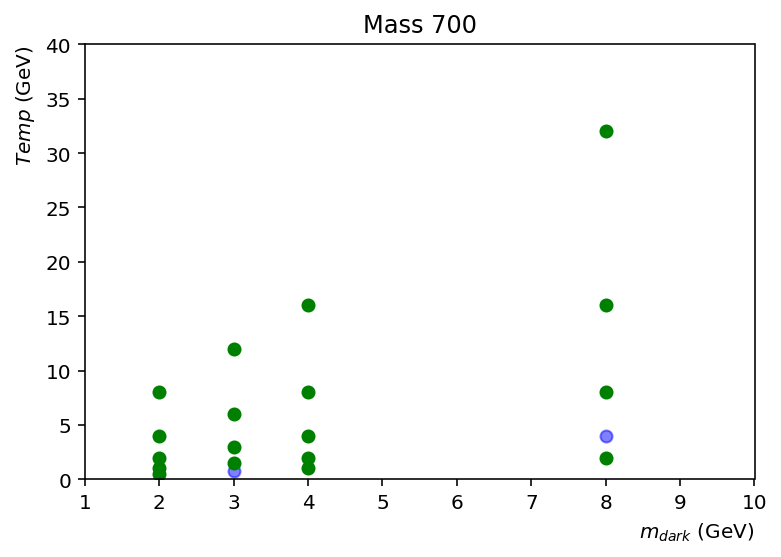

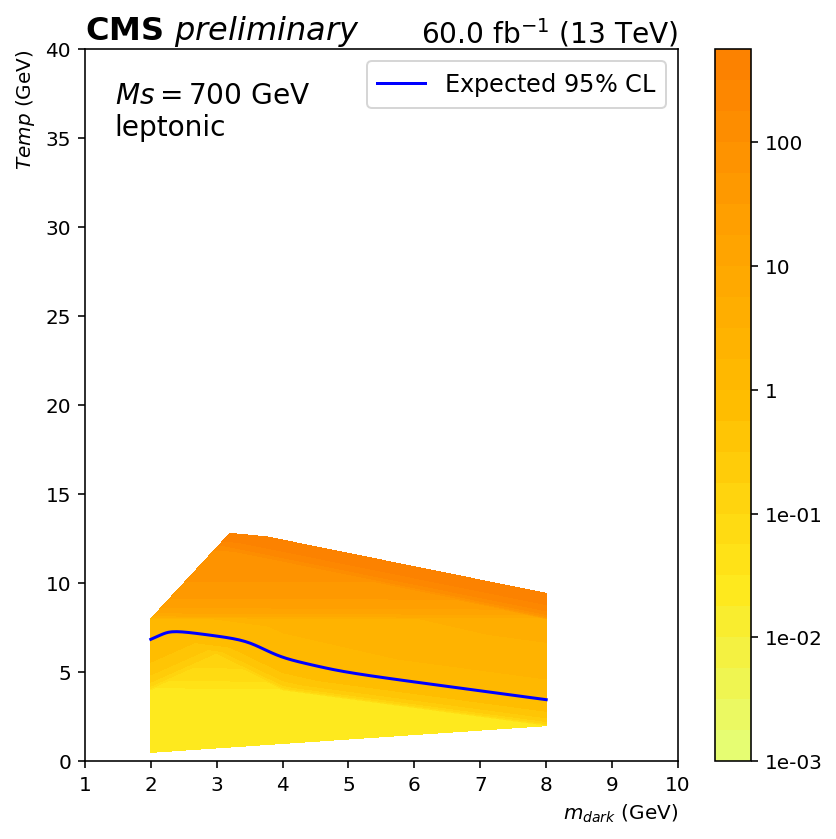

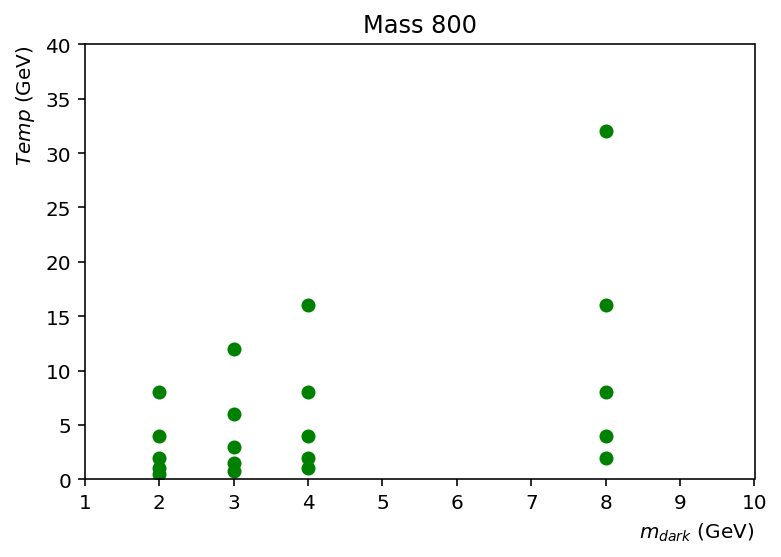

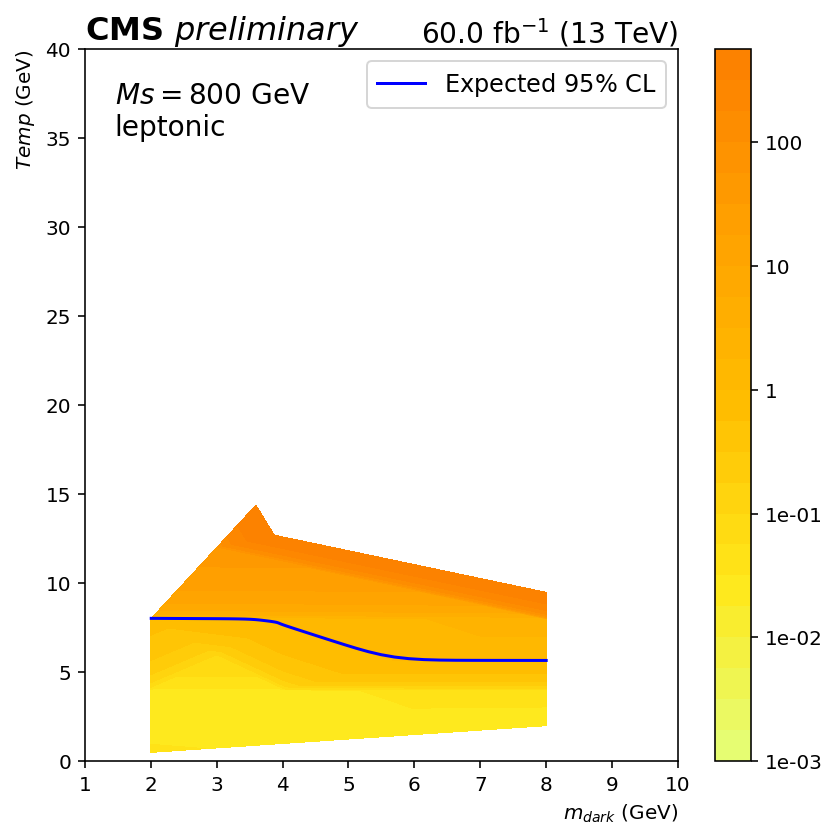

../higgsCombineGluGluToSUEP_HT1000_T32p0_mS900.000_mPhi8.000_T32.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


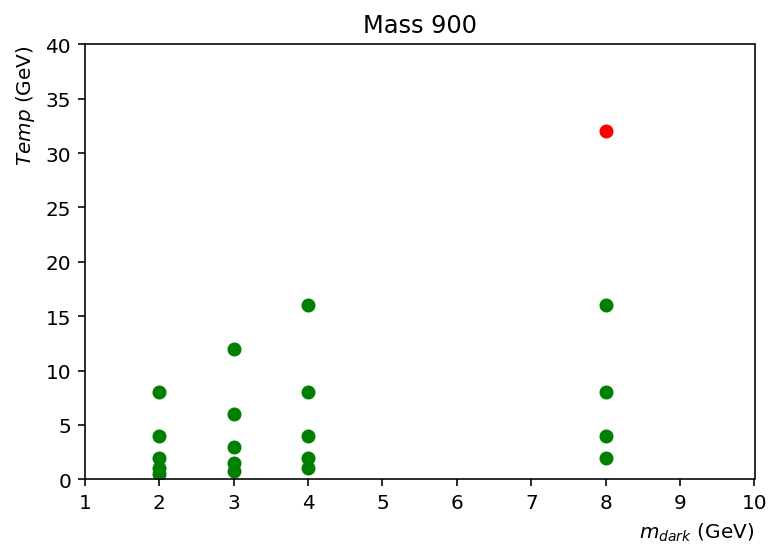

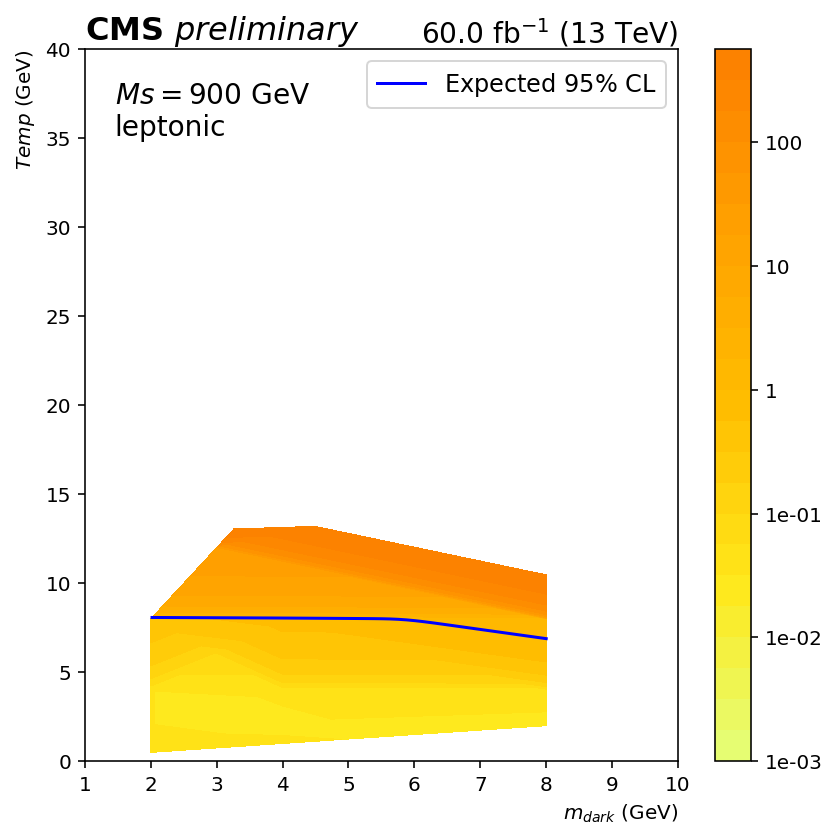

../higgsCombineGluGluToSUEP_HT1000_T32p0_mS1000.000_mPhi8.000_T32.000_modeleptonic_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


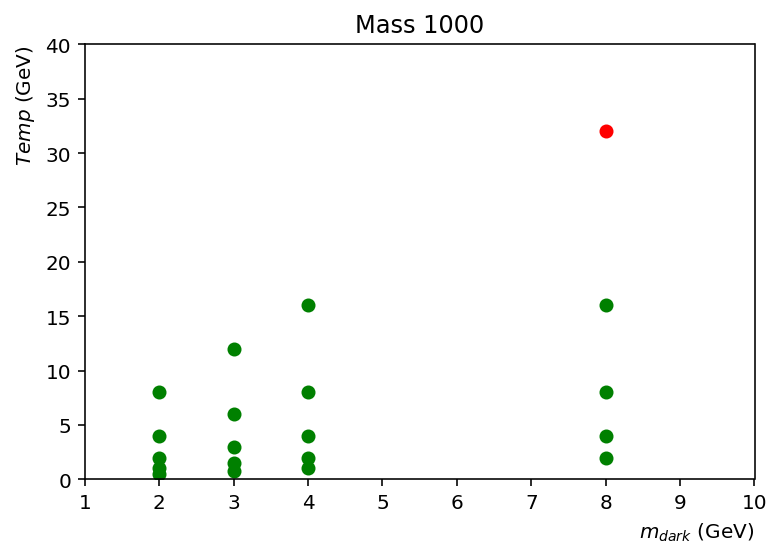

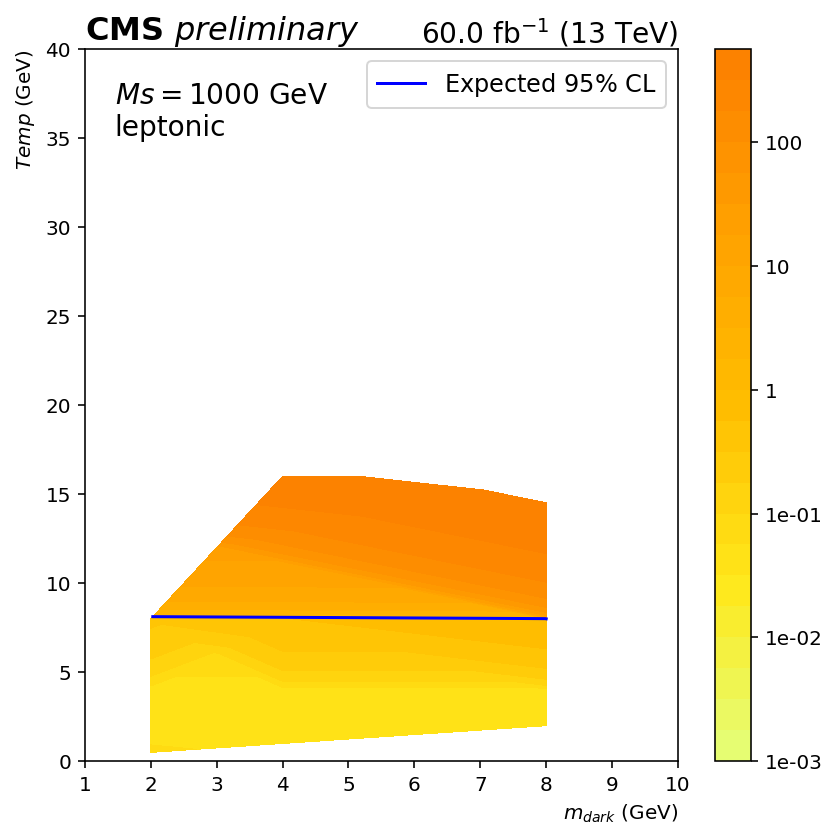

In [217]:
lines = []
for M in [125,200,300,400,500,600,700,800,900,1000]:
    #if M < 800: continue
    lines.append(plot_SUEP(get_params(M)))

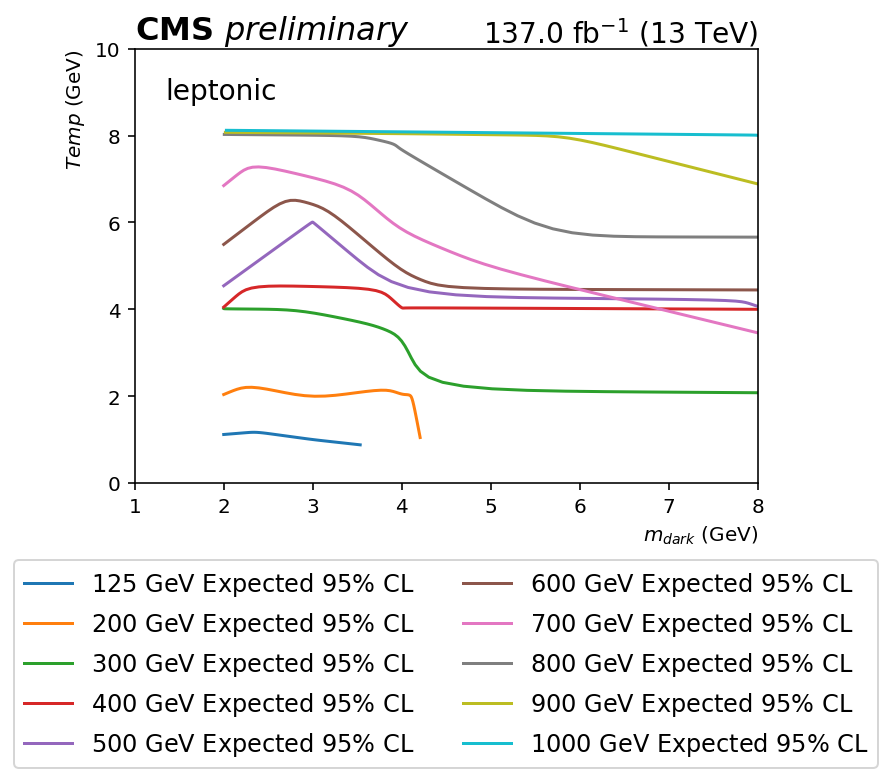

In [218]:
# To run through all masses
plt.figure(figsize=(6,6))
ax = plt.gca()
masses = [125,200,300,400,500,600,700,800,900,1000]
for i, line in enumerate(lines):
    #if masses[i] in [300,500,700,900]: continue
    #plt.plot(line[:,0], line[:,1], label="{} GeV Expected $95\%$ CL".format(masses[i]))#No smoothing
    plt.plot(*interpLimit(line, 2), label="{} GeV Expected $95\%$ CL".format(masses[i]))#Gaussian Filter smoothing

    
plt.xlabel(r"$m_{dark}$ (GeV)", x=1, ha='right')
plt.ylabel(r"$Temp$ (GeV)", y=1, ha='right')
cms = plt.text(
    0., 1., u"CMS $\it{preliminary}$",
    fontsize=16, fontweight='bold',
    horizontalalignment='left', 
    verticalalignment='bottom', 
    transform=ax.transAxes
)
lumi = plt.text(
    1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 137.0,
    fontsize=14, horizontalalignment='right', 
    verticalalignment='bottom', 
    transform=ax.transAxes
)
    
info = plt.text(
    0.05, 0.87, r"{}".format(decaymode),
    fontsize=14, horizontalalignment='left', 
    verticalalignment='bottom', 
    transform=ax.transAxes
)
    
plt.xlim([1, 8])
plt.ylim([0, 10])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=2, fancybox=True, fontsize=12)
plt.tight_layout()
#plt.savefig("/home/submit/freerc/public_html/SUEP_summary_crowded/2D_summary_limits_{}.pdf".format(decaymode), bbox_inches='tight')
#plt.savefig("/home/submit/freerc/public_html/SUEP_summary_crowded/2D_summary_limits_{}.png".format(decaymode), bbox_inches='tight')